In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/phd/project_af')

In [2]:
# pip install sklearn==0.23.1 

In [3]:
# pip install torch

In [4]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
## Progress bar
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder # need to upgrade to new version

import scipy.io

In [5]:
# load data
data = pd.read_csv("./data/data_9s.csv")
data.head(5)

0    1    2    3    4    5    6    7    8    9  ...  2694  2695  2696  \
0 -127 -162 -197 -229 -245 -254 -261 -265 -268 -268  ...   -48   -49   -50   
1  -41  -35  -28  -19   12   69  151  257  382  522  ...    10    10    10   
2    7    7    6    4    3    2    2    3    4    6  ...    53    50    46   
3  128  157  189  226  250  257  262  265  268  269  ...    -2     0     1   
4   13   15   18   21   24   27   31   35   41   48  ...  -154  -134  -112   

   2697  2698  2699  2700   2701    2702  2703  
0   -49   -48   -45     N  train  A00001     0  
1     9     9     8     N  train  A00001     1  
2    42    36    29     N  train  A00001     2  
3     4     7    10     N   test  A00002     0  
4   -88   -66   -31     N   test  A00002     1  

[5 rows x 2704 columns]

In [6]:
def load_tensor(g):
    df = data.loc[data.iloc[:,2701]==g,:]
    init = True
    for i in range(min(3,df.shape[0]//1000)):
        if init:
            x = torch.load("./data/x_"+g+"_sub"+str(i)+".pth")
            y = torch.load("./data/y_"+g+"_sub"+str(i)+".pth")
            x_spec = torch.load("./data/x_spec_"+g+"_sub"+str(i)+".pth")
            init = False
        else: 
            x_sub = torch.load("./data/x_"+g+"_sub"+str(i)+".pth")
            x_spec_sub = torch.load("./data/x_spec_"+g+"_sub"+str(i)+".pth")
            y_sub = torch.load("./data/y_"+g+"_sub"+str(i)+".pth")
            x = torch.cat((x, x_sub), dim=0)
            y = torch.cat((y, y_sub), dim=0)
            x_spec = torch.cat((x_spec, x_spec_sub), dim=0)
    return x, x_spec, y
    

In [7]:
# loop through every 1000 rows per group 
x_train, x_spec_train, y_train = load_tensor("train")
x_valid, x_spec_valid, y_valid = load_tensor("valid")
x_test, x_spec_test, y_test = load_tensor("test")



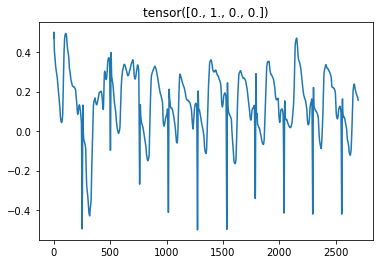

<function matplotlib.pyplot.show(close=None, block=None)>

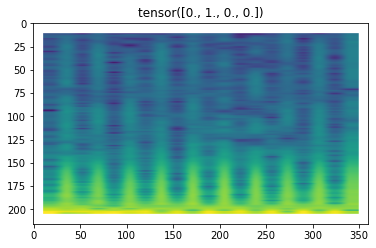

In [8]:
# visualize one of the signals in data set
plt.plot(x_test[5,0,:])
#plt.axis("off")
plt.title(str(y_test[5]))
plt.show();

# visualize one of the spectrograms in data set
plt.imshow(x_spec_test[5,:,:,:].permute(1,2,0))
#plt.axis("off")
plt.title(str(y_test[5]))
plt.show

torch.Size([3, 216, 360])


<function matplotlib.pyplot.show(close=None, block=None)>

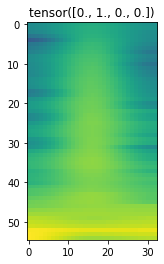

In [9]:
print(x_spec_test[5,:,:,:].shape)
# visualize one of the spectrograms in data set
plt.imshow(x_spec_test[5,:,150:205,20:53].permute(1,2,0))
#plt.axis("off")
plt.title(str(y_test[5]))
plt.show

In [10]:
x_train = x_spec_train
x_valid = x_spec_valid



# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(x_train) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_valid, y_valid)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = False)

333


# Conv2d on spectrogram

In [3]:
from model_classes import *

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Device", device)


Device cuda


In [2]:
model_name = "cnn_conv2d_vgg16"

if model_name.__eq__("cnn_conv2d_vgg16"):
    model = cnn_conv2d_vgg16(dim_out=4)

if model_name.__eq__("cnn_conv2d_ggl"):
    model = cnn_conv2d_ggl(dim_out=4)

if model_name.__eq__("cnn_conv2d_diy"):
    model = cnn_conv2d_diy(dim_out=4)

sum(p.numel() for p in model.parameters() if p.requires_grad )#& ~isinstance(p, torch.nn.parameter.UninitializedParameter) )

/home/jq2uw/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jq2uw/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'device' is not defined

In [ ]:
torch.cuda.empty_cache()
import os
lr_list = [1, 0.01, 0.005, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
file_path = './model/'+str(model_name)+'.pth' # Define the file path where the model is saved

if not os.path.exists(file_path):
    # first round of training
    model = cnn_conv2d(dim_out=4).to(device) # Create a new instance of your model
    loss_module = nn.CrossEntropyLoss()
    lr_past = lr_list[0]
else:
    print("continue from last checkpoint")
    # in case the first round of training breaks
    # load checkpoint 'model', 'optimizer' back in to continue training
    checkpoint = torch.load(file_path)# Load the model and other training-related information
    model = cnn_conv2d(dim_out=4).to(device) # Create a new instance of your model
    model.load_state_dict(checkpoint['model_state_dict']) # Load model weights
    loss_module = checkpoint['loss_module']
    lr_past = checkpoint['lr'] # check model folder to see what is the last learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_past) # initiate a object here
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])# Load optimizer state if needed

tl_trace = []
vl_trace = []
ta_trace = []
va_trace = []
tf_trace = []
vf_trace = []
for lr in [l for l in lr_list if l < lr_past]:
    print("learning rate = "+str(lr))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    tl, vl, ta, va, tf, vf = train_model(model, optimizer, train_loader, loss_module, num_epochs=num_epochs)
    # keep track of training and validation evaluation matrics
    tl_trace = tl_trace + tl
    vl_trace = vl_trace + vl
    ta_trace = ta_trace + ta
    va_trace = va_trace + va
    tf_trace = tf_trace + tf
    vf_trace = vf_trace + vf
    eval_df = pd.DataFrame({"tl":tl_trace,
                           "vl":vl_trace,
                           "ta":ta_trace,
                           "va":va_trace,
                           "tf":tf_trace,
                           "vf":vf_trace})
    # Save the model's state dictionary and any other necessary information
    torch.save({
        "eval_df": eval_df,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),  
        'loss_module': loss_module,
        'lr': lr,
    }, file_path)
    print(f'Model saved to {file_path}')

In [16]:
# pip install torchvision
from torchvision import models
import torch.nn as nn
class cnn_conv2d(nn.Module):

    def __init__(self, dim_out):
        super().__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2) 
        self.conv2d_1 = nn.Conv2d(3, 3, (55, 33), stride=(1, 1))
        self.conv2d_2 = nn.Conv2d(3, 3, (5, 5), stride=(1, 1))
        self.conv2d_3 = nn.Conv2d(3, 3, (3, 3), stride=(1, 1))
        self.vgg16 = models.vgg16(pretrained=True).to(device)
        self.flat = nn.Flatten()
#         self.l1 = nn.Linear(1000, 500)
#         self.l2 = nn.Linear(500, 300)
#         self.l3 = nn.Linear(300, 100)
        self.l4 = nn.Linear(1000, dim_out)


    def forward(self, x):
#         x = self.conv2d_1(x)
#         x = self.relu(x)
#         x = self.conv2d_2(x)
#         x = self.relu(x)
#         x = self.conv2d_3(x)
#         x = self.relu(x)
        x = self.vgg16(x)
        x = self.flat(x)
#         x = self.l1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.l2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.l3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        x = self.l4(x)

        return x
    
    
model = cnn_conv2d(dim_out=4)
sum(p.numel() for p in model.parameters() if p.requires_grad )#& ~isinstance(p, torch.nn.parameter.UninitializedParameter) )

138378198

In [17]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs):
    # Set model to train mode
    model.train()

    # Training loop
    train_loss_trace = list()
    train_acc_trace = list()
    train_f1_trace = list()
    valid_loss_trace = list()
    valid_acc_trace = list()
    valid_f1_trace = list()

    for epoch in tqdm(range(num_epochs)):
        
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            # preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            # loss = loss_module(preds, data_labels.float())
            loss = loss_module(preds, data_labels)

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

        # monitor evaluation matrics on train / valid sets for each epoch
        train_loss, train_acc, train_f1 = eval_model(model, train_loader, "train")
        valid_loss, valid_acc, valid_f1 = eval_model(model, valid_loader, "valid")
        # early stop criteria here, stop early
        if len(train_f1_trace)>0:
            if train_f1 < 0.1*max(train_f1_trace): # if current f1 drop 10% of the best
                break
        
        train_loss_trace.append(train_loss)
        train_acc_trace.append(train_acc)
        train_f1_trace.append(train_f1)
        valid_loss_trace.append(valid_loss)
        valid_acc_trace.append(valid_acc)
        valid_f1_trace.append(valid_f1)
        
        
#     # for dubugging purpose only
#     for parameter in model.parameters(): print(parameter)

    return train_loss_trace, valid_loss_trace, train_acc_trace, valid_acc_trace, train_f1_trace, valid_f1_trace

In [18]:
# define the evaluation matrix as physionet challenge 2017

def eval_model(model, data_loader, evalon):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        preds = torch.empty(0,4).to(device)
        trues = torch.empty(0,4).to(device)
        pred_ls = torch.empty(0).to(device)
        data_ls = torch.empty(0).to(device)


        for data_inputs, data_labels in data_loader:

    #             # convert to spectrogram!!
    #             data_inputs = x2spec(data_inputs)

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            pred_l = torch.max(model(data_inputs).data, 1)[1]
            data_l = torch.max(data_labels, 1)[1] # convert onehot responce to labels

            # append pred
            pred_ls = torch.cat((pred_ls, pred_l), 0)
            data_ls = torch.cat((data_ls, data_l), 0)

            # concatenate predicted values of all batchs of current epoch, is there more efficient way of collecting predictions?
            preds = torch.cat((preds, model(data_inputs)), 0)
            trues = torch.cat((trues, data_labels), 0)

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_l == data_l).sum()
            num_preds += data_labels.shape[0]

    # f1 
    f1_0 = 2*( (pred_ls==0) & (data_ls==0) ).sum() / ((pred_ls==0).sum() + (data_ls==0).sum() )
    f1_1 = 2*( (pred_ls==1) & (data_ls==1) ).sum() / ((pred_ls==1).sum() + (data_ls==1).sum() )
    f1_2 = 2*( (pred_ls==2) & (data_ls==2) ).sum() / ((pred_ls==2).sum() + (data_ls==2).sum() )
    f1_3 = 2*( (pred_ls==3) & (data_ls==3) ).sum() / ((pred_ls==3).sum() + (data_ls==3).sum() )
    f1 = (f1_0 + f1_1 + f1_2 + f1_3)/4

    # accuracy
    acc = true_preds / num_preds # this is a tensor object
    acc = acc.to('cpu').numpy().reshape(-1)[0] # this is probably a stupid way to get the value out of a tensor

    # loss
    loss = loss_module(preds, trues)

#     print(preds)
#     print(trues)
        
    print(str(evalon)+f" accuracy: {100.0*acc:4.2f}%" + f" loss: {loss:1.4f}" + f" f1: {f1:1.4f}")
    return loss, acc, f1


# init and continue training model

In [ ]:
torch.cuda.empty_cache()
import os
lr_list = [1, 0.01, 0.005, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
file_path = './model/cnn_conv2d_vgg16.pth'# Define the file path where the model is saved

if not os.path.exists(file_path):
    # first round of training
    model = cnn_conv2d(dim_out=4).to(device) # Create a new instance of your model
    loss_module = nn.CrossEntropyLoss()
    lr_past = lr_list[0]
else:
    print("continue from last checkpoint")
    # in case the first round of training breaks
    # load checkpoint 'model', 'optimizer' back in to continue training
    checkpoint = torch.load(file_path)# Load the model and other training-related information
    model = cnn_conv2d(dim_out=4).to(device) # Create a new instance of your model
    model.load_state_dict(checkpoint['model_state_dict']) # Load model weights
    loss_module = checkpoint['loss_module']
    lr_past = checkpoint['lr'] # check model folder to see what is the last learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_past) # initiate a object here
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])# Load optimizer state if needed

tl_trace = []
vl_trace = []
ta_trace = []
va_trace = []
tf_trace = []
vf_trace = []
for lr in [l for l in lr_list if l < lr_past]:
    print("learning rate = "+str(lr))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    tl, vl, ta, va, tf, vf = train_model(model, optimizer, train_loader, loss_module, num_epochs=num_epochs)
    # keep track of training and validation evaluation matrics
    tl_trace = tl_trace + tl
    vl_trace = vl_trace + vl
    ta_trace = ta_trace + ta
    va_trace = va_trace + va
    tf_trace = tf_trace + tf
    vf_trace = vf_trace + vf
    eval_df = pd.DataFrame({"tl":tl_trace,
                           "vl":vl_trace,
                           "ta":ta_trace,
                           "va":va_trace,
                           "tf":tf_trace,
                           "vf":vf_trace})
    # Save the model's state dictionary and any other necessary information
    torch.save({
        "eval_df": eval_df,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),  
        'loss_module': loss_module,
        'lr': lr,
    }, file_path)
    print(f'Model saved to {file_path}')

learning rate = 0.01


train accuracy: 32.10% loss: 1.0965 f1: 0.1215
valid accuracy: 27.40% loss: 1.0997 f1: 0.1075
train accuracy: 55.67% loss: 1.0088 f1: 0.1827
valid accuracy: 60.27% loss: 1.0018 f1: 0.1920
train accuracy: 55.93% loss: 0.9961 f1: 0.1803
valid accuracy: 60.63% loss: 0.9877 f1: 0.1899
train accuracy: 55.87% loss: 0.9722 f1: 0.1792
valid accuracy: 60.63% loss: 0.9683 f1: 0.1887
train accuracy: 55.93% loss: 0.9623 f1: 0.1803
valid accuracy: 60.67% loss: 0.9617 f1: 0.1900
train accuracy: 56.60% loss: 0.9621 f1: 0.2710
valid accuracy: 55.80% loss: 0.9734 f1: 0.2560
train accuracy: 56.27% loss: 0.9739 f1: 0.2962
valid accuracy: 51.60% loss: 0.9910 f1: 0.2693
train accuracy: 47.53% loss: 0.9807 f1: 0.2502
valid accuracy: 40.77% loss: 1.0099 f1: 0.2153
train accuracy: 40.83% loss: 1.0076 f1: 0.2023
valid accuracy: 34.07% loss: 1.0558 f1: 0.1681
train accuracy: 39.50% loss: 1.0233 f1: 0.1922
valid accuracy: 33.43% loss: 1.0821 f1: 0.1638
train accuracy: 52.60% loss: 0.9372 f1: 0.2996
valid accurac